# to_Mark_generate_DF_with_Haralick_tsne_and_TilesImages
*Leo Portes, 2024-06-12**

In [1]:
# Loading mmodules

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt # for plotting
from time import time
import pandas as pd
import seaborn as sns
import os
from matplotlib import image as plt_image
from tqdm import tqdm 

import mahotas # Haralick features
from joblib import Parallel, delayed


from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# specific functions

from openTSNE import TSNE

def return_tsne(X, perplexity=15,metric="euclidean"):
    early_exaggeration = "auto" # auto->12. 
    learning_rate = "auto" #max([X.shape[0]/12, 200]) # auto-> N/exaggeration
    n_iter=500 # default 500, paper says default is 1000
    
    tsne = TSNE(
        perplexity = perplexity,
        initialization="pca",
        metric = metric,
        early_exaggeration = early_exaggeration,
        learning_rate = learning_rate,
        n_jobs=24, # more jobs will crash the the kernel!
        random_state=42,
        verbose=False)
    
    return tsne.fit(X)



def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    
    ref: https://stackoverflow.com/questions/16856788/slice-2d-array-into-smaller-2d-arrays
    """
    h, w = arr.shape
    assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
    assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))


# Haralick features
import mahotas 
def get_haralick_features(image, distance=1):
    return mahotas.features.haralick(image, return_mean=True, distance=distance)


##################################################

def pre_processing(img0, w=40, rescale_tiles=True):
    

    # 0.Rescaling the whole image to [0, 255]   ##########################
    # (to keep consistency accross notebooks)
    img = 255*(img0 - img0.min())/(img0.max() - img0.min())


    # 1.Image cropping  ##########################
    #    (so we can split the image into perfect squared tiles)
    #w = 40 # eg, 40 means 40x40 tiles
    N_r, N_c = [int(np.floor(i/w)) for i in img.shape]
    #print("- Number of rows and columns after tiling:", N_r, N_c)
    img = img[:N_r*w, :N_c*w].copy()
    #print("- Cropped image shape:", img.shape)

    # 2.Image segmentation (getting tiles) ##########################
    im_tls = blockshaped(img,w,w)
    N_tls = im_tls.shape[0]
    #print("- Variable im_tls shape:", im_tls.shape)


    # 3.Amplitude normalization of each tile ################
    def rescale_image_0_255(im_array):
        im_range = im_array.max() - im_array.min()

        if im_range == 0:
            # image is "flat". Return original values, assuming whole image was in [0, 255]
            return im_array
        else:
            return 255*(im_array-im_array.min())/im_range

    if rescale_tiles: 
        im_tls = [rescale_image_0_255(im_tls[i,:,:]) for i in range(im_tls.shape[0])]


    # 4. Changing dtype because of the Haralick function, and from LIST to NP Array
    im_tls = np.array(im_tls ,dtype=np.uint8)
    #print("\n- Tiles stored in the 3D array im_tls of shape", im_tls.shape)
    
    return img, im_tls


########################################################

def get_standardized_Haralick_features(im_tls):
    
    N_tls = im_tls.shape[0]

    # Haralick features
    res = Parallel(n_jobs=-2)(delayed(get_haralick_features)(im_tls[i]) for i in range(N_tls))
    res = np.array(res)
    print(res.shape)

    # Normalize The feature vectors
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler() 
    scaler.fit(res) 
    X = scaler.transform(res)
    
    return X

# Loading data

Select here the images you want to use by adding the file names to the list *file_name_list*:

In [3]:
# loading data

file_path = r"../data/"

file_name_list = ["grav_clip2", "mag_clip2a"] # list of image files to load



# loading images
from PIL import Image

img0_list = [np.array(Image.open("%s%s.tif"%(file_path, i)))
             for i in file_name_list] 


# Sanity check: shape of each image
for i in range(len(img0_list)):
    print("%s shape:"%(file_name_list[i]), img0_list[i].shape)

grav_clip2 shape: (1512, 1826)
mag_clip2a shape: (1512, 1826)


## Visual inspection

- Explicit robuts percentile code, just for future reference
-416.18809204101564 618.300998535155


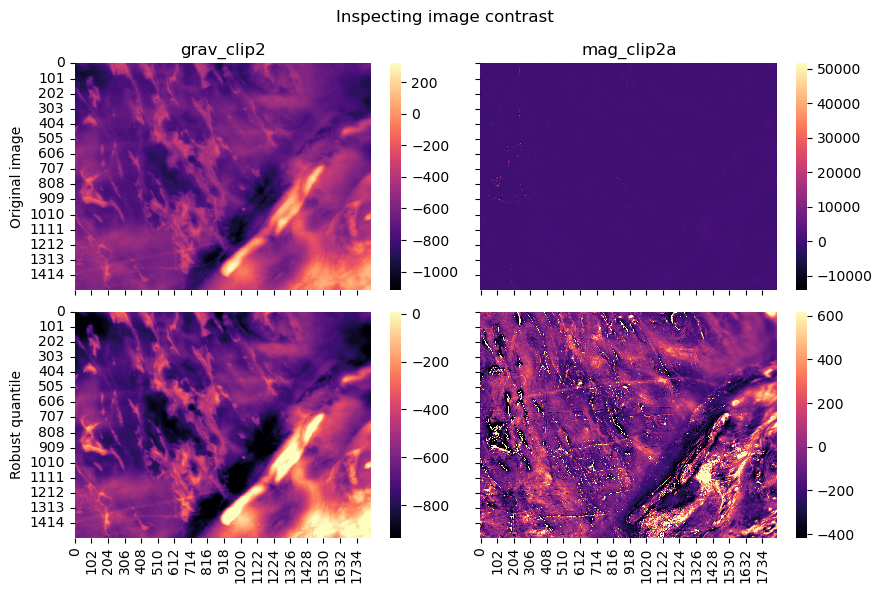

In [9]:
# plotting | Inspecting image contrast

fig, axes = plt.subplots(2,2, figsize=(9,6), sharey=True, sharex=True)

for i in range(2):
    axes[0,i].set_title(file_name_list[i])
    sns.heatmap(img0_list[i], cmap="magma", robust=False, rasterized=True, ax=axes[0,i])
    sns.heatmap(img0_list[i], cmap="magma", robust=True,  rasterized=True, ax=axes[1,i])

    
axes[0,0].set_ylabel("Original image")
axes[1,0].set_ylabel("Robust quantile")

fig.suptitle("Inspecting image contrast")
fig.tight_layout()

print("- Explicit robuts percentile code, just for future reference")
vmin = np.percentile(img0_list[file_idx], 2) 
vmax = np.percentile(img0_list[file_idx], 98) 
print(vmin, vmax)

# Image pre-processing 


In this notebook we will:
* **Image cropping** - cropping the image to have an integer number of non-overlaping segments.
* **Image segmentation** - split the image into several tiles of size im_tls
* **Amplitude normalization** of each tile - rescale to $[0, 255]$ individually. 
    
    
**Remarks**: 
* *img_list* is a list with the cropped images.
* im_tls_list is a list of 3D numpy arrays of shape $[N_{tiles}, w, w]$.
* Haralick features are computed from the arrays in *im_tls_list*. 

In [10]:
w = 40 # size of the square tiles

In [11]:
# pre-processing and tiling

img_list, im_tls_list = list(), list()

for i in range(len(file_name_list)):
    temp1, temp2 = pre_processing(img0_list[i], w)
    img_list.append(temp1), im_tls_list.append(temp2)
    


# Things I'll need later. They were inside the pre_processing funciton
N_r, N_c = [int(np.floor(i/w)) for i in img_list[0].shape] 
N_tls = im_tls_list[0].shape[0]

# Sanity check
print("- Each entry of list im_tls_list has shape:", im_tls_list[0].shape)
print("\n- Tiles stored in the 3D array im_tls of shape", im_tls_list[0].shape)

- Each entry of list im_tls_list has shape: (1665, 40, 40)

- Tiles stored in the 3D array im_tls of shape (1665, 40, 40)


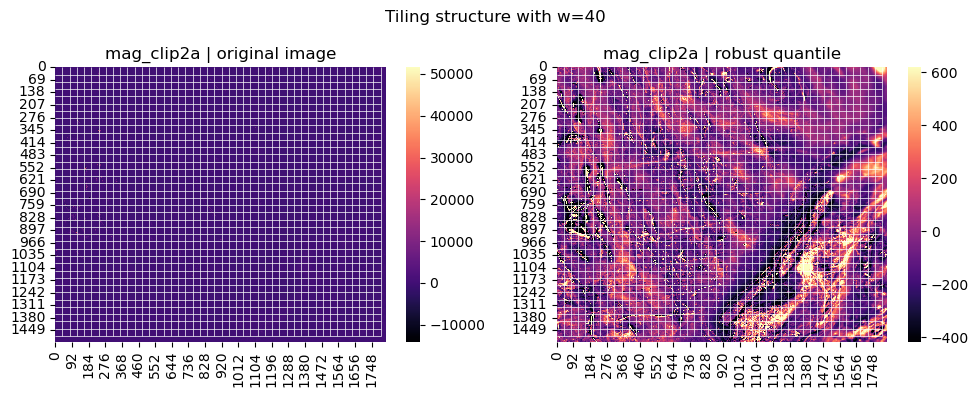

In [12]:
# Plotting | inspect the effect of cropping and segmentation

file_idx = 1 # select here the image you want to plot

fig, axes = plt.subplots(1,2,figsize=(10,4))

i=0
axes[i].set_title(file_name_list[file_idx]+" | original image")
sns.heatmap(img0_list[file_idx], cmap="magma", robust=False, rasterized=True, ax=axes[i])


i+=1
axes[i].set_title(file_name_list[file_idx]+" | robust quantile")
sns.heatmap(img0_list[file_idx], cmap="magma", robust=True, rasterized=True, ax=axes[i])

for ax in axes:
    lw=0.5
    ax.vlines(x=[i-lw for i in np.arange(w,img0_list[i].shape[1], w)], ymin=0, ymax=N_r*w, colors="white",linewidth=lw)
    ax.hlines(y=[i-lw for i in np.arange(w,img0_list[i].shape[0], w)], xmin=0, xmax=N_c*w, colors="white",linewidth=lw)

fig.suptitle("Tiling structure with w=%i"%(w))

fig.tight_layout();

# Haralick features
If the tiles are small and the image large, it is better to parellelize like in here.

In [13]:
# Calculating the Haralick texture features of each image

X_list = [get_standardized_Haralick_features(im_tls_list[i])
          for i in tqdm(range(len(im_tls_list)))]


# Data fusion | concatenating the 13 features
feat_lbls = [r"$f_{%i,%i}$"%(i+1, j+1) for i in range(2) for j in range(13)]
df_X = pd.DataFrame(np.hstack(X_list), columns=feat_lbls)


print("- Data matrix df_X has shape", (df_X.shape))

display(df_X.describe())

 50%|██████████████████████▌                      | 1/2 [00:02<00:02,  2.40s/it]

(1665, 13)


100%|█████████████████████████████████████████████| 2/2 [00:04<00:00,  2.04s/it]

(1665, 13)
- Data matrix df_X has shape (1665, 26)


,"$f_{1,1}$","$f_{1,2}$","$f_{1,3}$","$f_{1,4}$","$f_{1,5}$","$f_{1,6}$","$f_{1,7}$","$f_{1,8}$","$f_{1,9}$","$f_{1,10}$",...,"$f_{2,4}$","$f_{2,5}$","$f_{2,6}$","$f_{2,7}$","$f_{2,8}$","$f_{2,9}$","$f_{2,10}$","$f_{2,11}$","$f_{2,12}$","$f_{2,13}$"
count,1.665000e+03,1.665000e+03,1.665000e+03,1.665000e+03,1.665000e+03,1.665000e+03,1.665000e+03,1.665000e+03,1.665000e+03,1.665000e+03,...,1.665000e+03,1.665000e+03,1.665000e+03,1.665000e+03,1.665000e+03,1.665000e+03,1.665000e+03,1.665000e+03,1.665000e+03,1.665000e+03
mean,8.449697e-16,-6.193244e-15,9.186272e-14,3.457761e-15,2.539177e-15,-3.207044e-15,-3.521241e-15,1.905876e-14,-1.338936e-14,3.281726e-15,...,1.450958e-16,1.621659e-15,-3.439624e-15,1.314397e-15,4.542779e-15,-1.559780e-15,-1.041276e-15,3.303064e-15,9.217852e-15,6.497305e-14
std,1.000300e+00,1.000300e+00,1.000300e+00,1.000300e+00,1.000300e+00,1.000300e+00,1.000300e+00,1.000300e+00,1.000300e+00,1.000300e+00,...,1.000300e+00,1.000300e+00,1.000300e+00,1.000300e+00,1.000300e+00,1.000300e+00,1.000300e+00,1.000300e+00,1.000300e+00,1.000300e+00
min,-7.916422e-01,-1.474823e+00,-5.646464e+00,-2.284706e+00,-2.096311e+00,-2.646614e+00,-2.280623e+00,-5.552709e+00,-6.212726e+00,-1.931801e+00,...,-1.110712e+00,-1.163366e+00,-1.794605e+00,-1.032447e+00,-4.694303e+00,-5.250387e+00,-9.725365e-01,-3.921055e+00,-2.561694e+00,-1.002224e+01
25%,-4.602948e-01,-7.222468e-01,-3.763673e-01,-6.935046e-01,-6.290460e-01,-6.738196e-01,-6.922630e-01,-3.973353e-01,-3.711938e-01,-6.940888e-01,...,-7.638372e-01,-7.164367e-01,-8.289025e-01,-7.559977e-01,-6.259312e-01,-4.033166e-01,-6.343015e-01,-6.035347e-01,-7.571065e-01,-1.538772e-01
50%,-2.797961e-01,-2.677419e-01,2.795146e-01,-1.078452e-01,-1.936861e-01,4.321342e-02,-1.085055e-01,2.680087e-01,2.577668e-01,-1.829549e-01,...,-3.246173e-01,-3.180382e-01,-1.037044e-01,-3.616834e-01,2.450849e-01,4.127562e-01,-3.106512e-01,9.513793e-02,5.027208e-02,4.266001e-01
75%,5.038217e-02,4.595897e-01,7.195042e-01,6.307956e-01,3.689393e-01,6.854238e-01,6.322276e-01,7.034104e-01,6.645237e-01,5.234136e-01,...,4.598716e-01,3.926222e-01,6.785576e-01,4.244714e-01,7.840276e-01,7.147739e-01,2.009955e-01,7.711223e-01,7.598042e-01,5.872802e-01
max,1.611050e+01,5.764561e+00,1.153238e+00,4.018561e+00,5.814249e+00,2.740856e+00,4.006993e+00,1.410873e+00,1.763830e+00,7.201220e+00,...,4.388166e+00,4.532449e+00,3.593891e+00,4.430375e+00,1.452650e+00,9.923339e-01,6.941141e+00,1.970625e+00,2.407726e+00,6.312523e-01


# t-SNE

## Perplexity consistency test

In [16]:
# t-SNE | for some values of perplexity

perp_list = [5, 10, 20, 30, 40, 50, 60, 100]
X_tsne_list = [return_tsne(df_X.values, perplexity, "euclidean") for perplexity in  tqdm(perp_list)]

print("- kl_divergence:")
["%.2f"%i.kl_divergence for i in X_tsne_list]

100%|█████████████████████████████████████████████| 8/8 [00:19<00:00,  2.46s/it]

- kl_divergence:


['1.34', '1.42', '1.41', '1.37', '1.36', '1.30', '1.28', '1.05']

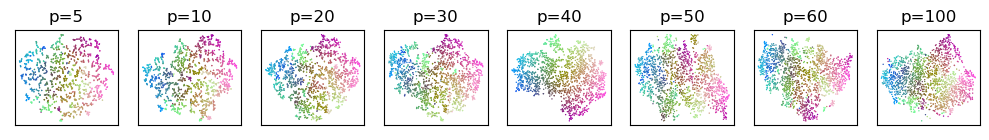

In [17]:
# plotting tsne for several perplexities

i_tsne = 4 # coloring points using the i^th embedding as the reference


from sklearn.preprocessing import MinMaxScaler

# reduced colors

reducedColors = X_tsne_list[i_tsne].copy()
d_center = (X_tsne_list[i_tsne][:,0]**2+X_tsne_list[i_tsne][:,1]**2)**0.5
reducedColors = np.hstack((reducedColors, d_center[:, None]))

from sklearn.preprocessing import MinMaxScaler
scaler =  MinMaxScaler(feature_range=(0, 1)) 
reducedColors = scaler.fit_transform(reducedColors) # can return [0.0, 1.0000000000000002] !!!! ahhhh!!!
reducedColors = reducedColors/(reducedColors.max()) # solving the problem [0.0, 1.0000000000000002]



# plotting tsne for several perplexities #############

fig, axes = plt.subplots(1,8,figsize=(10,1.5))

for i in range(8): 
    axes[i].set_title("p=%i"%(perp_list[i]))
    axes[i].scatter(X_tsne_list[i][:,0], X_tsne_list[i][:,1], 
                    s=1, c=reducedColors, edgecolors='none', rasterized=True)
    
#axes[0].set_ylabel("%s"%(geo_class), fontsize=12);

for ax in axes:
    ax.set(xticks=[], yticks=[])

fig.tight_layout()


## Single perplexity

In [18]:
perplexity = 40 # perplexity of the chosen reference tsne

temp = return_tsne(df_X.values, perplexity, "euclidean")
df_tsne = pd.DataFrame(temp, columns=["comp_%i"%(1+i) for i in range(temp.shape[1])])

# merging tsne data with Haralick texture features data
df_tsne = pd.concat([df_tsne, df_X], axis=1, ignore_index=False)


## Embedding images into the data frame

In [19]:
# Embedding images into the data frame

from io import BytesIO
from PIL import Image
import base64

def embeddable_image(img_data):
    
    image = Image.fromarray(img_data, mode='L')
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()

N_tls = im_tls_list[0].shape[0]

for i in tqdm(range(len(file_name_list))):
    df_tsne["image_%s"%(file_name_list[i])] = [embeddable_image(im_tls_list[i][j]) 
                                               for j in range(N_tls)]
    
    
display(df_tsne.head())

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  5.20it/s]


,comp_1,comp_2,"$f_{1,1}$","$f_{1,2}$","$f_{1,3}$","$f_{1,4}$","$f_{1,5}$","$f_{1,6}$","$f_{1,7}$","$f_{1,8}$",...,"$f_{2,6}$","$f_{2,7}$","$f_{2,8}$","$f_{2,9}$","$f_{2,10}$","$f_{2,11}$","$f_{2,12}$","$f_{2,13}$",image_grav_clip2,image_mag_clip2a
0,6.807340,-12.699410,0.194413,-0.916113,0.647294,-0.543771,1.032045,-0.682225,-0.539366,0.073122,...,-0.304796,-0.487892,0.236145,0.632741,-0.699024,1.007154,0.662627,0.283684,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA..."
1,-12.988842,2.909099,-0.443010,-0.681694,0.755008,0.277095,-0.600932,0.419586,0.280973,1.004452,...,0.256364,-0.076212,0.648961,0.873080,-0.872153,1.574497,-0.028229,0.529043,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA..."
2,-7.056424,-12.275893,-0.048456,-0.348508,0.300492,-0.253396,0.189545,-0.911383,-0.251761,-0.061143,...,-0.170031,0.206781,0.549350,0.533747,-0.543570,0.889954,-0.402965,0.556447,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA..."
3,-17.795529,12.587688,0.032167,-0.867496,0.732416,-0.207646,0.019786,-0.479710,-0.203205,0.543200,...,-0.305690,0.091103,0.237323,0.267533,-0.363097,0.615390,-0.257601,0.509949,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA..."
4,-24.337994,-12.112560,0.053267,-1.078864,0.893719,-0.231236,0.378011,-0.891892,-0.225689,0.149100,...,0.882385,0.040029,0.662913,0.427580,-0.229080,-0.066438,-0.836656,0.591656,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA..."


In [20]:
# Saving embedding 

save_name = "df_tsne_consolidated.csv"

df_tsne.to_csv(file_path+save_name)

print("Dataframe saved with name:\n", save_name)

Dataframe saved with name:
 df_tsne_consolidated.csv
